In [ ]:
"""
Purpose: Implementation fo DiffPool
graph coarsening manner

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
#sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

from importlib import reload

In [3]:
data_path = Path("/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/")
list(data_path.iterdir())

[PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/m65_AutoProofreadNeuronGNN.ipynb'),
 PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/df_cell_type_fine_limbs_dist_thresh_exc.pbz2'),
 PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/df_morphometrics.pbz2'),
 PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/Compartment_Proof_GNN_Data_vp1.ipynb'),
 PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/df_compartment_proof.pbz2'),
 PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/Axon_vs_Dedrite_GNN_Data.ipynb'),
 PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classification/Data_Prep/Axon_vs_Dedrite_GNN_Data_vp2.ipynb'),
 PosixPath('/neuron_mesh_tools/Auto_Proofreading/Minnie65_Analysis/GNN_Classif

In [4]:
#python_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

In [5]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric import transforms

# for the dataset object
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import DenseDataLoader

In [6]:
#pytorch_tools modules
import preprocessing_utils as pret
import geometric_models as gm

# Step 0: Getting the cell type labels (Graph Labels) -- 

In [7]:
df_fine = pu.csv_to_df(data_path / Path("df_fine.csv"))
df_fine

,pt_root_id,cell_type_fine_label,cell_type_coarse,table_of_origin,nucleus_id,pt_position
0,864691135660737776,5P_PT,excitatory,bodor_pt_cells,526436,[304160 185008 17299]
1,864691135472306482,5P_PT,excitatory,bodor_pt_cells,495010,[287632 192944 19549]
2,864691135494401680,5P_PT,excitatory,bodor_pt_cells,494888,[285712 190768 19231]
3,864691135502157405,5P_PT,excitatory,bodor_pt_cells,337966,[203520 194512 22991]
4,864691135476398504,5P_PT,excitatory,bodor_pt_cells,302951,[181952 207456 20474]
...,...,...,...,...,...,...
4620,864691135939789313,6P,excitatory,cg_cell_type_calls,371770,[219296 217536 19502]
4621,864691135939790081,5P_IT,excitatory,cg_cell_type_calls,164927,[129472 203312 21381]
4622,864691135501851970,6P,excitatory,cg_cell_type_calls,273900,[170592 252544 23342]
4623,864691136020226040,23P,excitatory,cg_cell_type_calls,222567,[149408 120832 19937]


# Step 1: Loading the Graph Data

In [8]:
gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"
dense_adj = True

In [9]:
data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134884741626,0,326888,LAYER_2/3,V1,"[{'nodelist': ['L0_22', 'L0_21', 'L0_23', 'L0_...",NaN
1,864691134884748026,0,366181,LAYER_5,V1,"[{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_...",4P
2,864691134884749818,0,330319,LAYER_4,V1,"[{'nodelist': ['L0_6', 'L0_7', 'L0_8', 'L0_5',...",NaN
3,864691134884750074,0,326374,LAYER_2/3,V1,"[{'nodelist': ['L0_33', 'L0_29', 'L0_36', 'L0_...",NaN
4,864691134884750842,0,490973,LAYER_4,RL,"[{'nodelist': ['L0_0', 'L0_18', 'L1_3', 'L3_2'...",NaN
...,...,...,...,...,...,...,...
12824,864691137197182273,0,335443,LAYER_5,V1,"[{'nodelist': ['L0_12', 'L0_1', 'L0_9', 'L0_18...",NaN
12825,864691137197188161,0,296634,LAYER_4,V1,"[{'nodelist': ['L0_9', 'L0_21', 'L3_2', 'L3_3'...",23P
12826,864691137197196865,0,299940,LAYER_5,V1,"[{'nodelist': ['L0_1', 'L0_5', 'L0_7', 'L0_6',...",NaN
12827,864691137197232961,0,553624,LAYER_2/3,RL,"[{'nodelist': ['L0_31', 'L0_32', 'L0_34', 'L0_...",NaN


In [10]:
"""
Note the cell_type_fine is the column
that has all of the graph data stored
"""

'\nNote the cell_type_fine is the column\nthat has all of the graph data stored\n'

In [11]:
data_df.query("cell_type_fine_label == cell_type_fine_label")

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
1,864691134884748026,0,366181,LAYER_5,V1,"[{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_...",4P
27,864691134884879610,0,304873,LAYER_5,V1,"[{'nodelist': ['L6_0', 'L0_0', 'L0_2', 'L0_3',...",IT_short
33,864691134885028602,0,305198,LAYER_5,V1,"[{'nodelist': ['L0_11', 'L8_0', 'L5_0', 'L4_1'...",6P_CT
67,864691134917517322,0,294357,LAYER_2/3,V1,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2', 'L0_3',...",23P
68,864691134917543946,0,260743,LAYER_4,V1,"[{'nodelist': ['L0_5', 'L0_6', 'L0_7', 'L0_3',...",4P
...,...,...,...,...,...,...,...
12804,864691137196912961,0,426337,LAYER_4,RL,"[{'nodelist': ['L0_5', 'L0_8', 'L0_11', 'L0_2'...",23P
12820,864691137197083457,0,264318,LAYER_5,V1,"[{'nodelist': ['L0_21', 'L0_18', 'L0_22', 'L0_...",5P_IT
12823,864691137197177665,0,269491,LAYER_5,V1,"[{'nodelist': ['L0_10', 'L3_0', 'L0_5', 'L0_3'...",IT_small_tuft
12825,864691137197188161,0,296634,LAYER_4,V1,"[{'nodelist': ['L0_9', 'L0_21', 'L3_2', 'L3_3'...",23P


In [12]:
data_dict = data_df[["cell_type_fine"]].iloc[1].to_list()[0][0]
data_dict

{'nodelist': array(['L0_10', 'L0_11', 'L0_12', 'L0_7', 'L0_8', 'L0_13', 'L0_14',
        'L0_3', 'L0_5', 'L0_0', 'L0_9', 'L0_17', 'L0_18', 'L0_15', 'L0_16',
        'L0_1', 'L0_2', 'L0_4', 'L0_6', 'L1_2', 'L1_0', 'L1_1', 'L1_3',
        'L2_3', 'L2_2', 'L2_5', 'L2_1', 'L2_6', 'L2_0', 'L2_4', 'L3_1',
        'L3_0', 'L3_2', 'L3_3', 'L3_4', 'L4_0', 'L4_1', 'L4_2', 'L4_3',
        'L4_4', 'L5_0', 'L5_1', 'L5_2', 'L5_3', 'L5_4', 'L6_2', 'L6_0',
        'L6_1', 'L7_0'], dtype=object),
 'features': array(['mesh_volume', 'n_spines', 'n_synapses_head', 'n_synapses_neck',
        'n_synapses_post', 'n_synapses_pre', 'skeletal_length',
        'total_spine_volume', 'width_upstream', 'width_downstream',
        'apical_label', 'basal_label', 'skeleton_vector_downstream_phi',
        'skeleton_vector_downstream_theta', 'skeleton_vector_upstream_phi',
        'skeleton_vector_upstream_theta', 'width_no_spine'], dtype=object),
 'adjacency': array([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0

# Step 2: Creating the Pytorch Dataset

# -- a) Getting Means and Std Dev for Normalization --

In [13]:
all_batch_df = pd.concat([nxio.feature_df_from_gnn_info(
    k[0],
    return_data_labels_split = False) for k in data_df[gnn_task].to_list()])

if label_name is not None:
    all_batch_df = all_batch_df[[k for k in 
            all_batch_df.columns if k not in nu.convert_to_array_like(label_name)]]
else:
    all_batch_df = all_batch_df
    
# will use these to normalize the data
col_means = all_batch_df.mean(axis=0).to_numpy()
col_stds = all_batch_df.std(axis=0).to_numpy()

all_batch_df_norm = pu.normalize_df(all_batch_df,column_means=col_means,
                                 column_stds = col_stds)
all_batch_df_norm.std()

mesh_volume                         1.0
n_spines                            1.0
n_synapses_head                     1.0
n_synapses_neck                     1.0
n_synapses_post                     1.0
n_synapses_pre                      1.0
skeletal_length                     1.0
total_spine_volume                  1.0
width_upstream                      1.0
width_downstream                    1.0
apical_label                        1.0
basal_label                         1.0
skeleton_vector_downstream_phi      1.0
skeleton_vector_downstream_theta    1.0
skeleton_vector_upstream_phi        1.0
skeleton_vector_upstream_theta      1.0
width_no_spine                      1.0
dtype: float64

In [14]:
col_to_delete = [
    "skeleton_vector_downstream_phi",      
    "skeleton_vector_downstream_theta",    
    "skeleton_vector_upstream_phi",        
    "skeleton_vector_upstream_theta", 
    "mesh_volume",
]

col_to_keep = None

# --- b) Creating the Dataset Class --

In [15]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6P': 7,
 '6P_CT': 8,
 '6P_IT': 9,
 '6P_U': 10,
 'IT_big_tuft': 11,
 'IT_short': 12,
 'IT_small_tuft': 13,
 None: 0}

In [16]:
total_labels,label_counts

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'IT_big_tuft', 'IT_short', 'IT_small_tuft'],
       dtype=object),
 array([  4, 529, 387, 113,   2,  20,   4,   6,  17,   2,  13,  15,  10]))

In [17]:
features_to_delete = [
    "skeleton_vector_downstream_phi",      
    "skeleton_vector_downstream_theta",    
    "skeleton_vector_upstream_phi",        
    "skeleton_vector_upstream_theta", 
    "mesh_volume",
]

features_to_keep = None

In [18]:
def pytorch_data_from_gnn_info(
    gnn_info,
    y = None,
    verbose = False,
    normalize = True,
    features_to_delete=None,
    features_to_keep = None
    ): 
    """
    Purpose: To convert our data format into pytorch Data object

    Pseudocode: 
    1) Create the edgelist (turn into tensor)
    2) Get the 
    """
    edgelist = torch.tensor(xu.edgelist_from_adjacency_matrix(
        array = gnn_info["adjacency"],
        verbose = False,
    ).T,dtype=torch.long)

    x,y_raw = nxio.feature_df_from_gnn_info(
        gnn_info,
        return_data_labels_split = True)
    if y is None:
        y = y_raw
        
    if not type(y) == str:
        y = None
        
    y_int = np.array(cell_type_map[y] ).reshape(1,-1)
    
    if normalize:
        x = (x-col_means)/col_stds
    
    # --- keeping or not keeping sertain features
    gnn_features = gnn_info["features"]

    keep_idx = np.arange(len(gnn_features))
    if features_to_delete is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k not in features_to_delete])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER DELETE= {keep_idx}")
    if features_to_keep is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k in features_to_keep])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER KEEP = {keep_idx}")

    x = x[:,keep_idx]

    x = torch.tensor(x,dtype=torch.float)
    y = torch.tensor(y_int,dtype=torch.long)


    if verbose:
        print(f"x.shape = {x.shape},y.shape ={y.shape}")

    data = Data(x=x,y=y,edge_index=edgelist)
    return data

In [19]:
class CellTypeDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        #return ['some_file_1', 'some_file_2', ...]
        return [str(data_filepath.absolute())]

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.
    #     download_url(url, self.raw_dir)
    #     ...

    def process(self):
        # Read data into huge `Data` list.
        #data_list = [...]

#         if data_df is None:
#             data_df = su.decompress_pickle(self.raw_file_names[0])

        
        
        data_list = []
        for k,y in tqdm(zip(
            data_df[gnn_task].to_list(),
            data_df[graph_label].to_list())):
            
            data_list.append(pytorch_data_from_gnn_info(
                k[0],
                y=y,
                features_to_delete=features_to_delete,
                features_to_keep = features_to_keep,
                verbose = False))

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [20]:
processed_data_folder = data_path / Path(f"{gnn_task}")#_processed_dense")
#su.rm_dir(processed_data_folder)
processed_data_folder.mkdir(exist_ok = True)

In [21]:
processed_data_folder = data_path / Path(f"{gnn_task}")#_processed_dense")

#gets the maximum number of nodes in any of the graphs
max_nodes = np.max(all_batch_df_norm.index.to_numpy()) + 1


class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes


transform_norm = transforms.Compose([
    transforms.ToUndirected(),
    T.ToDense(max_nodes),
    #transforms.NormalizeFeatures(),
])



dataset = CellTypeDataset(
    processed_data_folder.absolute(),
    pre_transform = transform_norm,
    pre_filter = MyFilter(),
    )

In [22]:
dataset_num_node_features = dataset.num_node_features
dataset_num_classes = dataset.num_classes

In [23]:
# looking at the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset_num_node_features}')
print(f'Number of classes: {dataset_num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: CellTypeDataset(12829):
Number of graphs: 12829
Number of features: 12
Number of classes: 14

Data(x=[221, 12], y=[1, 1], adj=[221, 221], mask=[221])
Number of nodes: 221
Number of edges: 0
Average node degree: 0.00


# --- c) Splitting the Data into Labeled and unlabeled

In [24]:
labeled_mask = np.array(
    [True if k.y[0][0] > 0 else False for k in dataset]
).astype('int')
dataset_labeled = dataset[np.where(labeled_mask)[0]]
len(dataset_labeled)

1122

In [25]:
dataset_curr = dataset_labeled
torch.manual_seed(12345)
dataset_curr = dataset_curr.shuffle()

# --- d) Split Train/Validation/Test

In [26]:
"""
Purpose: To turn percentages into raw lengths

"""

'\nPurpose: To turn percentages into raw lengths\n\n'

In [27]:
n_train = int(len(dataset_curr)*0.7)
n_test = len(dataset_curr) - n_train

batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset_curr,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

if dense_adj:
    data_loader_mod = DenseDataLoader
else:
    data_loader_mod = DataLoader


train_loader = data_loader_mod(train_dataset, batch_size=batch_size,shuffle = True)
test_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle=False)

test size = 224.0 (0.2 %)
validation size = 224.0 (0.2 %)
train_size = 674.0
data_lengths_with_train = [674 224 224]
Number of training graphs: 674
Number of test graphs: 224
Number of val graphs: 224


/usr/local/lib/python3.6/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


# Step 2: Picking the Model Type

In [28]:
# -- Diffpool model ----
gm.DiffPoolSimple(
    dataset_num_node_features=dataset_num_node_features, 
    dataset_num_classes=dataset_num_classes,
    n_hidden_channels=64, 
    n_pool_layers=4,
    max_nodes=max_nodes,
)

DiffPoolSimple(
  (gnn0_pool): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(12, 64)
      (1): DenseGCNConv(64, 64)
      (2): DenseGCNConv(64, 56)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn0_embed): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(12, 64)
      (1): DenseGCNConv(64, 64)
      (2): DenseGCNConv(64, 64)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn1_pool): DiffPoolSimpleGNN(
    (convs): Mo

# -- Generic GCN --

# --- Graph Sage Model ---

In [30]:
from torch_geometric.nn import SAGEConv
"""
Source: https://colab.research.google.com/github/sachinsharma9780/interactive_tutorials/blob/master/notebooks/example_output/Comprehensive_GraphSage_Guide_with_PyTorchGeometric_Output.ipynb#scrollTo=ROXBserO_amj


How GraphSAGE is different: 

The GraphSage is different from GCNs is two ways: i.e.
1) Instead of taking the entire K-hop neighborhood of a 
    target node, GraphSage first samples or prune the K-hop
    neighborhood computation graph and then perform the 
    feature aggregation operation on this sampled graph 
    in order to generate the embeddings for a target node. 
2) During the learning process, in order to generate the node
    embeddings; GraphSage learns the aggregator function 
    whereas GCNs make use of the symmetrically normalized 
    graph Laplacian.

"""
class SAGE(torch.nn.Module):
    def __init__(
        self, 
        dataset_num_node_features,
        n_hidden_channels, 
        dataset_num_classes,
        n_layers=3):
        super(SAGE, self).__init__()

        self.num_layers = n_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(dataset_num_node_features, n_hidden_channels))
        for _ in range(n_layers - 2):
            self.convs.append(SAGEConv(n_hidden_channels, n_hidden_channels))
        self.convs.append(SAGEConv(n_hidden_channels, dataset_num_classes))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

# Step 3: Training the Model

In [31]:
model_name = "DiffPoolSimple"
n_epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cpu


In [32]:
architecture_kwargs = dict(
    n_hidden_channels = 8, 
    #n_hidden_channels=64, 
    #first_heads=8, 
    #output_heads=1, 
    #dropout=0.6,
    #global_pool_type="mean",
    n_pool_layers=4,
    max_nodes=max_nodes,
)

model = getattr(gm,model_name)(
    dataset_num_node_features=dataset_num_node_features,
    dataset_num_classes=dataset_num_classes,
    **architecture_kwargs
    )

print(model)

DiffPoolSimple(
  (gnn0_pool): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(12, 8)
      (1): DenseGCNConv(8, 8)
      (2): DenseGCNConv(8, 56)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn0_embed): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(12, 8)
      (1): DenseGCNConv(8, 8)
      (2): DenseGCNConv(8, 8)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn1_pool): DiffPoolSimpleGNN(
    (convs): ModuleList(
    

In [33]:
from torch.utils.tensorboard import SummaryWriter

tensorboard_dir = Path("./tensorboard")
tensorboard_dir.mkdir(exist_ok=True)

tensorboard_file_name = (f'{model_name}' 
                         + "_".join([f"{k}_{v}" for k,v in architecture_kwargs.items()]))
print(f"tensorboard_file_name = {tensorboard_file_name}")
tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
writer = SummaryWriter(tensorboard_file)

tensorboard_file_name = DiffPooln_hidden_channels_8_n_pool_layers_4_max_nodes_221


In [34]:
import evaluation_utils as evu
import torch.nn.functional as F

print(model)

learning_rate=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# weights = weight#[0.1,0.5,,1,0.7,1,1,1]
# class_weights = torch.FloatTensor(weights).to(device)
class_weights = None
tensor_map = None

def train():
    model.train()

    for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        else:
            out = model(data)
        y_true = data.y.squeeze_()
        #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
        loss = F.nll_loss(
            torch.log(out), y_true,
            weight = class_weights,
        )  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        return loss


def test(loader,verbose = False):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        else:
            out = model(data)
         
        y_pred = out.argmax(dim=1)  # Use the class with highest probability.
        y_true = data.y.squeeze_()
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
#         error_idx = np.where(pred > 0)[0]
#         if len(error_idx) > 0:
#             print(f"error_idx = {error_idx}")
    y_pred = torch.cat(y_pred_list)
    y_true = torch.cat(y_true_list)
    
    return evu.metric_dict(
        y_true,
        y_pred,
        tensor_map=tensor_map,
        metrics=["accuracy"],
    )

log_to_tensorboard = True
for epoch in range(0, n_epochs):
    loss = train()
    writer.add_scalar('loss',loss,epoch) # new line
    train_metric_dict = test(train_loader)#train_loader)
    val_metric_dict = test(val_loader)#test_loader)
    print(f'Epoch: {epoch:03d}, loss = {loss}')
    for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
        print_log = f"   {type_name} metrics: "
        for k,v in metric_dict.items():
            if log_to_tensorboard:
                writer.add_scalar(f'{type_name}_{k}',v,epoch)
            print_log += f" {k}: {v:4f},"
            
        print(print_log)

DiffPoolSimple(
  (gnn0_pool): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(12, 8)
      (1): DenseGCNConv(8, 8)
      (2): DenseGCNConv(8, 56)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn0_embed): DiffPoolSimpleGNN(
    (convs): ModuleList(
      (0): DenseGCNConv(12, 8)
      (1): DenseGCNConv(8, 8)
      (2): DenseGCNConv(8, 8)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn1_pool): DiffPoolSimpleGNN(
    (convs): ModuleList(
    

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3],y_pred_counts = [392 282]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3],y_pred_counts = [129  95]
Epoch: 009, loss = 1.4565433263778687
   train metrics:  accuracy: 0.390208,
   val metrics:  accuracy: 0.397321,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3],y_pred_counts = [381 293]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3],y_pred_counts = [141  83]
Epoch: 010, loss = 1.4257043600082397
   train metrics:  accuracy: 0.338279,
   val metrics:  accuracy: 0.366071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3],y_pred_counts = [308 366]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3],y_pred_counts = [100 124]
Epoch: 028, loss = 1.3146792650222778
   train metrics:  accuracy: 0.611276,
   val metrics:  accuracy: 0.580357,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3],y_pred_counts = [297 377]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3],y_pred_counts = [ 99 125]
Epoch: 029, loss = 1.2121888399124146
   train metrics:  accuracy: 0.611276,
   val metrics:  accuracy: 0.584821,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   

   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3],y_pred_counts = [ 90 134]
Epoch: 046, loss = 0.7274067997932434
   train metrics:  accuracy: 0.606825,
   val metrics:  accuracy: 0.584821,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3],y_pred_counts = [272 402]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3],y_pred_counts = [ 87 137]
Epoch: 047, loss = 1.1447718143463135
   train metrics:  accuracy: 0.596439,
   val metrics:  accuracy: 0.589286,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3],y_pred_counts = [258 416]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [264 369  41]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 88 130   6]
Epoch: 065, loss = 0.9834514856338501
   train metrics:  accuracy: 0.609792,
   val metrics:  accuracy: 0.584821,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [251 371  52]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 85 132   7]
Epoch: 066, loss = 1.1601722240447998
   train metrics:  accuracy: 0.615727,
   val metrics:  accuracy: 0.580357,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [268 318  88]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 86 106  32]
Epoch: 083, loss = 1.067633032798767
   train metrics:  accuracy: 0.609792,
   val metrics:  accuracy: 0.575893,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [254 312 108]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 87 101  36]
Epoch: 084, loss = 1.2534064054489136
   train metrics:  accuracy: 0.602374,
   val metrics:  accuracy: 0.575893,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [254 380  40]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 91 125   8]
Epoch: 101, loss = 0.9498134851455688
   train metrics:  accuracy: 0.623145,
   val metrics:  accuracy: 0.580357,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [268 367  39]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 91 124   9]
Epoch: 102, loss = 0.9319697618484497
   train metrics:  accuracy: 0.627596,
   val metrics:  accuracy: 0.580357,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [234 372  68]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 82 131  11]
Epoch: 119, loss = 0.902525782585144
   train metrics:  accuracy: 0.654303,
   val metrics:  accuracy: 0.598214,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [227 380  67]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 80 133  11]
Epoch: 120, loss = 0.7962399125099182
   train metrics:  accuracy: 0.637982,
   val metrics:  accuracy: 0.602679,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [257 321  96]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 97 107  20]
Epoch: 137, loss = 1.0037025213241577
   train metrics:  accuracy: 0.629080,
   val metrics:  accuracy: 0.593750,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [273 317  84]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 99 110  15]
Epoch: 138, loss = 0.9333499670028687
   train metrics:  accuracy: 0.626113,
   val metrics:  accuracy: 0.589286,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [195 394  85]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 67 132  25]
Epoch: 155, loss = 0.9199549555778503
   train metrics:  accuracy: 0.652819,
   val metrics:  accuracy: 0.598214,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [201 399  74]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 70 138  16]
Epoch: 156, loss = 0.7321094274520874
   train metrics:  accuracy: 0.645401,
   val metrics:  accuracy: 0.602679,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [231 365  78]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 77 129  18]
Epoch: 173, loss = 0.8539465069770813
   train metrics:  accuracy: 0.640950,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [229 361  84]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 76 130  18]
Epoch: 174, loss = 1.0731803178787231
   train metrics:  accuracy: 0.661721,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [208 377  89]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 63 131  30]
Epoch: 191, loss = 1.0306745767593384
   train metrics:  accuracy: 0.642433,
   val metrics:  accuracy: 0.575893,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [234 355  85]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 78 124  22]
Epoch: 192, loss = 0.7710691690444946
   train metrics:  accuracy: 0.635015,
   val metrics:  accuracy: 0.562500,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [221 344 109]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 73 120  31]
Epoch: 209, loss = 0.9554679989814758
   train metrics:  accuracy: 0.639466,
   val metrics:  accuracy: 0.580357,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [225 356  93]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 77 122  25]
Epoch: 210, loss = 1.011884331703186
   train metrics:  accuracy: 0.646884,
   val metrics:  accuracy: 0.598214,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [241 335  98]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 80 121  23]
Epoch: 227, loss = 1.2532950639724731
   train metrics:  accuracy: 0.658754,
   val metrics:  accuracy: 0.616071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [233 343  98]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 78 121  25]
Epoch: 228, loss = 0.9067350029945374
   train metrics:  accuracy: 0.654303,
   val metrics:  accuracy: 0.616071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [223 360  91]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 75 125  24]
Epoch: 245, loss = 0.8400869965553284
   train metrics:  accuracy: 0.664688,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [219 357  98]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 71 126  27]
Epoch: 246, loss = 0.8468976616859436
   train metrics:  accuracy: 0.664688,
   val metrics:  accuracy: 0.607143,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [493  92  89]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [163  33  28]
Epoch: 263, loss = 0.8702371716499329
   train metrics:  accuracy: 0.543027,
   val metrics:  accuracy: 0.491071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [247 334  93]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 58 136  30]
Epoch: 264, loss = 0.9605159759521484
   train metrics:  accuracy: 0.630564,
   val metrics:  accuracy: 0.602679,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [187 397  90]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 61 137  26]
Epoch: 281, loss = 1.2213528156280518
   train metrics:  accuracy: 0.648368,
   val metrics:  accuracy: 0.616071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [357 223  94]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 91 109  24]
Epoch: 282, loss = 0.9832432866096497
   train metrics:  accuracy: 0.605341,
   val metrics:  accuracy: 0.562500,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [230 361  83]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 80 127  17]
Epoch: 299, loss = 0.8945174217224121
   train metrics:  accuracy: 0.655786,
   val metrics:  accuracy: 0.598214,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4],y_pred_counts = [211 367  96]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4],y_pred_counts = [ 71 129  24]
Epoch: 300, loss = 0.9310615062713623
   train metrics:  accuracy: 0.652819,
   val metrics:  accuracy: 0.620536,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 32

   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 64 129  27   2   2]
Epoch: 316, loss = 0.8826777338981628
   train metrics:  accuracy: 0.670623,
   val metrics:  accuracy: 0.620536,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [197 375  90   3   9]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 64 129  26   2   3]
Epoch: 317, loss = 0.8195022940635681
   train metrics:  accuracy: 0.673590,
   val metrics:  accuracy: 0.620536,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [192 377  89   3  13]
   y_true_unique= [ 1  2  3  4  5 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [188 371 101   5   9]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 57 131  29   4   3]
Epoch: 334, loss = 0.791026771068573
   train metrics:  accuracy: 0.663205,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [184 371  87   6  26]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 56 131  28   3   6]
Epoch: 335, loss = 0.9989970922470093
   train metrics:  accuracy: 0.661721,
   val metrics:  accuracy: 0.616071,
   y_true_unique= [ 1  2  3  4  5  

   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 50 139  33   1   1]
Epoch: 351, loss = 0.9130378365516663
   train metrics:  accuracy: 0.645401,
   val metrics:  accuracy: 0.602679,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [172 384 115   1   2]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 52 138  31   2   1]
Epoch: 352, loss = 0.8776626586914062
   train metrics:  accuracy: 0.649852,
   val metrics:  accuracy: 0.620536,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [182 376 111   4   1]
   y_true_unique= [ 1  2  3  4  5 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [192 360  92   4  26]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 61 127  28   1   7]
Epoch: 369, loss = 0.8846997618675232
   train metrics:  accuracy: 0.660237,
   val metrics:  accuracy: 0.589286,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [199 354 107   2  12]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 9],y_pred_counts = [ 63 126  32   3]
Epoch: 370, loss = 0.8399938344955444
   train metrics:  accuracy: 0.672107,
   val metrics:  accuracy: 0.593750,
   y_true_unique= [ 1  2  3  4  5  6  7 

   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 68 122  25   4   5]
Epoch: 386, loss = 0.8777211904525757
   train metrics:  accuracy: 0.660237,
   val metrics:  accuracy: 0.638393,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [221 341 102   4   6]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 69 122  25   4   4]
Epoch: 387, loss = 0.7434520721435547
   train metrics:  accuracy: 0.664688,
   val metrics:  accuracy: 0.638393,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [222 343 102   5   2]
   y_true_unique= [ 1  2  3  4  5 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6],y_pred_counts = [228 325 114   7]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 71 121  26   5   1]
Epoch: 404, loss = 0.9046154022216797
   train metrics:  accuracy: 0.660237,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [221 334 101  12   6]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 71 122  23   5   3]
Epoch: 405, loss = 0.8677834272384644
   train metrics:  accuracy: 0.664688,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5  6  7 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [181 392  74   2  25]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 9],y_pred_counts = [ 58 135  23   8]
Epoch: 421, loss = 0.8973919153213501
   train metrics:  accuracy: 0.657270,
   val metrics:  accuracy: 0.616071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [180 391  75   2  26]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 9],y_pred_counts = [ 53 140  25   6]
Epoch: 422, loss = 0.7977664470672607
   train metrics:  accuracy: 0.663205,
   val metrics:  accuracy: 0.607143,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 

   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6],y_pred_counts = [ 67 125  26   6]
Epoch: 438, loss = 0.7544599175453186
   train metrics:  accuracy: 0.666172,
   val metrics:  accuracy: 0.607143,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6],y_pred_counts = [212 359  94   9]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6],y_pred_counts = [ 67 129  23   5]
Epoch: 439, loss = 0.7298358082771301
   train metrics:  accuracy: 0.683976,
   val metrics:  accuracy: 0.616071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [209 361  95   8   1]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13]

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [187 383  90   4  10]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 55 134  28   3   4]
Epoch: 456, loss = 0.9148908257484436
   train metrics:  accuracy: 0.675074,
   val metrics:  accuracy: 0.607143,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [190 381  96   4   3]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6 9],y_pred_counts = [ 55 137  28   3   1]
Epoch: 457, loss = 0.8445809483528137
   train metrics:  accuracy: 0.672107,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5 

   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6],y_pred_counts = [ 60 139  19   6]
Epoch: 473, loss = 0.8808909058570862
   train metrics:  accuracy: 0.675074,
   val metrics:  accuracy: 0.616071,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6],y_pred_counts = [208 380  80   6]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6],y_pred_counts = [ 65 138  17   4]
Epoch: 474, loss = 0.6070957779884338
   train metrics:  accuracy: 0.678042,
   val metrics:  accuracy: 0.629464,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6],y_pred_counts = [218 373  79   4]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_tru

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6],y_pred_counts = [242 343  84   5]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6],y_pred_counts = [ 83 121  17   3]
Epoch: 491, loss = 0.8566241264343262
   train metrics:  accuracy: 0.686944,
   val metrics:  accuracy: 0.611607,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13],y_true_counts = [  3 321 237  59   1   6   2   6  12   2   9  10   6]
   y_pred_unique= [2 3 4 6],y_pred_counts = [249 333  87   5]
   y_true_unique= [ 1  2  3  4  5  6  7  9 11 12 13],y_true_counts = [ 1 99 79 29  1  4  1  3  1  2  4]
   y_pred_unique= [2 3 4 6],y_pred_counts = [ 86 117  18   3]
Epoch: 492, loss = 0.8935161828994751
   train metrics:  accuracy: 0.692878,
   val metrics:  accuracy: 0.602679,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /pytorch_tools/Applications/Cell_Types_GNN/tensorboard --bind_all

# Step 4: Running Embedding for all cell types (Can Run in Batches)

In [35]:
all_data_loader = data_loader_mod(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

/usr/local/lib/python3.6/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


In [36]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
        out,gnn_loss, cluster_loss = model.encode(data)  # Perform a single forward pass.
        #y_true = data.y.reshape(-1,3)
    else:
        out = model.encode(data)

    out_array = out.detach().cpu().numpy()
    
    embeddings.append(out_array)
    labels.append(data.y.numpy().reshape(-1))
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/201 [00:00<?, ?it/s]

In [37]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'IT_big_tuft', 'IT_short', 'IT_small_tuft',
        'Unknown'], dtype=object),
 array([    4,   529,   387,   113,     2,    20,     4,     6,    17,
            2,    13,    15,    10, 11707]))

In [38]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([False,  True, False, ..., False, False,  True])

# Step 5: Plotting Embeddings

In [39]:
%matplotlib notebook
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

# PCA

In [40]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [41]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

<IPython.core.display.Javascript object>


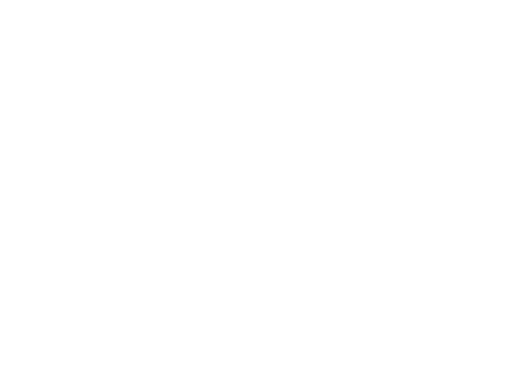

<IPython.core.display.Javascript object>


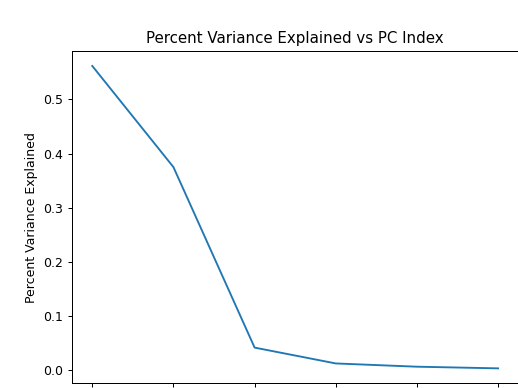

In [42]:
n_components_test=6
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

<IPython.core.display.Javascript object>


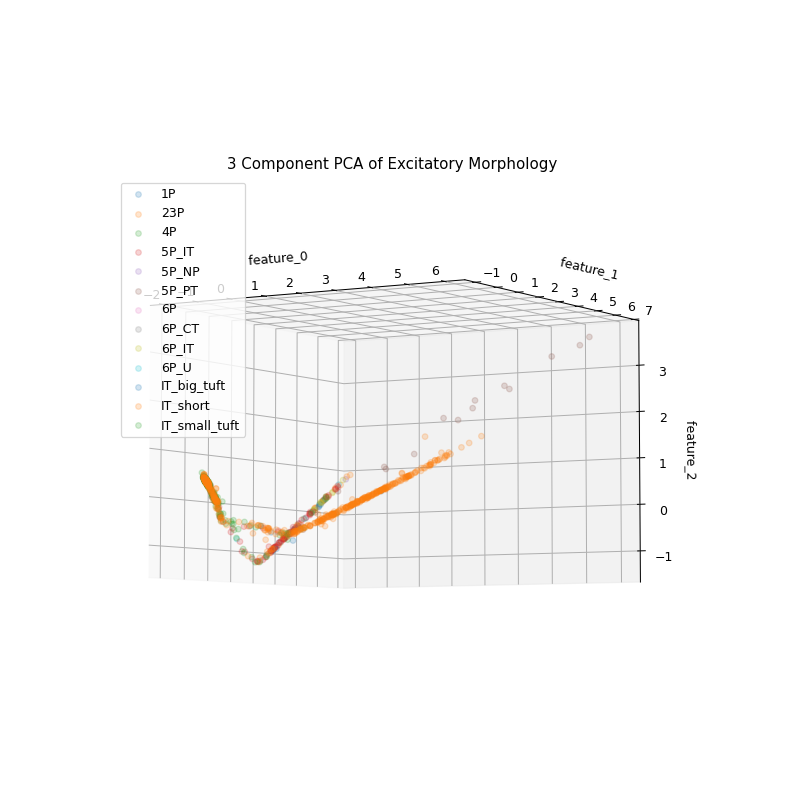

Text(0.5, 0.92, '3 Component PCA of Excitatory Morphology')

In [44]:
dim_red_name = "PCA"
W = pca_data["data_proj"][:,:n_components]

ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y = y,
    alpha = 0.2
)

ax.set_title(f"3 Component {dim_red_name} of Excitatory Morphology")


# MDS

<IPython.core.display.Javascript object>


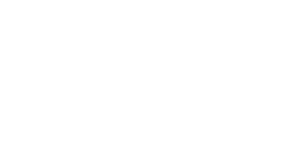

Text(0.5, 0.92, '3 Component MDS of DiffPool Labeled')

In [45]:
from sklearn.manifold import MDS
mds_model = MDS(n_components=n_components)
#returns the transformed data

X = X_data[labeled_mask_plotting].to_numpy()
y = y_labels[labeled_mask_plotting].to_numpy()


W = mds_model.fit_transform(X)

dim_red_name = "MDS"
ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y =y,
)

ax.set_title(f"3 Component {dim_red_name} of {model_name} Labeled")

# TSNE

In [46]:
dim_red_name = "TSNE"

In [47]:
from sklearn.manifold import TSNE
tsne_model = TSNE(
    n_components=n_components,
    #early_exaggeration = 4,
    #perplexity = 5
)

<IPython.core.display.Javascript object>


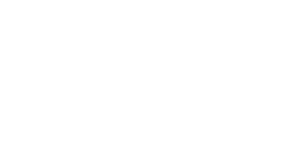

Text(0.5, 0.92, '3 Component TSNE of DiffPool Labeled')

In [48]:
X = X_data[labeled_mask_plotting].to_numpy()
y = y_labels[labeled_mask_plotting].to_numpy()

W = tsne_model.fit_transform(X)

ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y =y,
)

ax.set_title(f"3 Component {dim_red_name} of {model_name} Labeled")

In [49]:
from sklearn.manifold import TSNE
tsne_model = TSNE(
    n_components=n_components,
    #early_exaggeration = 100,
    perplexity = 3
)

<IPython.core.display.Javascript object>


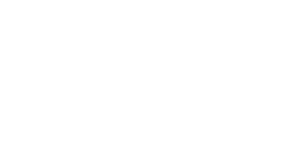

Text(0.5, 0.92, '3 Component TSNE of DiffPool Labeled')

In [50]:
X = X_data[labeled_mask_plotting].to_numpy()
y = y_labels[labeled_mask_plotting].to_numpy()

W = tsne_model.fit_transform(X)

ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y =y,
)

ax.set_title(f"3 Component {dim_red_name} of {model_name} Labeled")